In this notebook, I present the calculation and measurement of the expectation value and its uncertainty of the photon count operator $\hat{N}$ as a funtion of $\theta$ in IBMQ Osaka, Brisbane, Kyoto, Kyiv and Sherbrooke. Math and physics discussion are kept to a minimum here. For a detailed explanation, please refer to section II of 'Ensemble-Based Quantum-Token Protocol Benchmarked on IBM Quantum Processors' arXiv:2412.08530 (2024).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12, "text.usetex": True, "font.family": "cmr"})
from scipy.optimize import curve_fit

def sigma_s2(theta, N0, N1):
    """
    Calculate the shot noise squared for a given theta, N0 and N1.

    Parameters:
    theta (float): The angle in radians
    N0 (float): The number of counts for the 0 state
    N1 (float): The number of counts for the 1 state

    Returns:
    float: The shot noise
    """
    return np.cos(theta/2)**2*N0 + np.sin(theta/2)**2*N1

def sigma_q2(theta, N0, N1):
    """ 
    Calculate the projection noise squared for a given theta, N0 and N1.
    
    Parameters:
    theta (float): The angle in radians
    N0 (float): The number of counts for the 0 state
    N1 (float): The number of counts for the 1 state

    Returns:
    float: The projection noise
    """
    return N0**2*np.cos(theta/2)**2 + N1**2*np.sin(theta/2)**2 - sigma_s2(theta, N0, N1)**2

def sigma_total2(theta, N0, N1, sigma_exp):
    """ 
    Calculate the total noise squared for a given theta, N0, N1 and sigma_exp.
    
    Parameters:
    theta (float): The angle in radians
    N0 (float): The number of counts for the 0 state
    N1 (loat): The number of counts for the 1 state
    sigma_exp (float): The experimental uncertainty component of the total noise

    Returns:
    float: The total noise
    """
    return sigma_s2(theta, N0, N1) + sigma_q2(theta, N0, N1) + sigma_exp**2

def combined_fit(theta, N0, N1, sigma_exp):
    """
    Function to fit both the Rabi oscillation and the uncertainty at the same time for the parameters.

    Parameters:
    theta (float): The angle in radians
    N0 (float): The number of counts for the 0 state
    N1 (float): The number of counts for the 1 state
    sigma_exp (float): The experimental uncertainty component of the total noise

    Returns:
    array: Concatenated array of the expectation value of the operator N and the total noise in normalized units 
    """
    return np.concatenate( (sigma_s2(theta, N0, N1)/(N0+N1), sigma_total2(theta, N0, N1, sigma_exp)**.5/(N0+N1)) )

# Definition of variables
theta = np.linspace(0, np.pi, 40)
theta_osaka = np.linspace(0, 2*np.pi, 73)

In [5]:
# qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.timing_constraints import TimingConstraints

service = QiskitRuntimeService(channel="ibm_quantum", token="") # token ommited

def rabi_protocol(theta, phi):
    """
    Create a Rabi experiment protocol with given rotation angles theta and phi.

    Parameters:
    theta (float): The rotation angle in radians

    Returns:
    QuantumCircuit: The quantum circuit implementing the Rabi experiment    
    """
    # Create the quantum circuit with 1 qubit and 1 classical bit for the N measurements
    protocol = QuantumCircuit(QuantumRegister(1), ClassicalRegister(1))

    protocol.reset(0) # Initialize
    protocol.append(RGate(theta, phi), [0]) # Rotate by theta
    protocol.measure(0, 0) # Measure

    return protocol

def optmized_transpilation(backend, protocol, timing_constraints):
    """
    Transpile the protocol to the backend with the given timing constraints with optimal parameters previously tested
    
    Parameters:
    backend (IBMQBackend): The backend to transpile the protocol
    protocol (QuantumCircuit): The quantum circuit to transpile
    timing_constraints (TimingConstraints): The timing constraints of the backend

    Returns:
    QuantumCircuit: The transpiled quantum circuit
    """
    pass_manager = generate_preset_pass_manager(optimization_level=0, # Optimization with inverse cancelation but no commutative cancellation
                                                backend=backend, # Use the backend to transpile
                                                layout_method='dense', # Take the qubit with longer T2 and smallest gate time
                                                routing_method='none', # As only one qubit is used, we don't need routing
                                                translation_method="translator", # Use the synthesis method to map the gates to the native operations of the backend, translator method can also be used but results in longer pulses
                                                approximation_degree=1, # No approximation of the gates
                                                timing_constraints=timing_constraints, # Use the timing constraints of the backend
                                            )
    return pass_manager.run(protocol)

def get_mu_std(jobs):
    """
    Calculate the mean and standard deviation of the results of the jobs.

    Parameters:
    jobs (list of Job): The list of jobs to calculate the mean and standard deviation

    Returns:
    np.array: The mean of the results
    """
    # Intialize empty arrays to store the mean and standard deviation of the results
    mean = np.empty(len(jobs), dtype=float)
    std = np.empty(len(jobs), dtype=float)

    for itr in range(len(jobs)):

        counts = jobs[itr].result().get_counts() # Get the counts of the results

        N0 = counts['0']
        N1 = counts['1']

        mean[itr] =  N1/(N0 + N1) # Calculate the mean
        std[itr] = ( N0* mean[itr] **2 + N1*( 1 - mean[itr] )**2 )**.5/(N0 + N1)**.5

    return mean, std

# 1. <a id='toc1_'></a>[Analytical Formulas](#toc0_)

I begin plotting the analytical formula of the total uncertainty for different values of $  N_0$, $N_1$ and $\sigma_{exp}$. As one can see, the quantum projection noise is maximum at $\theta = \pi/2$ and the shot noise is maximum at $\theta = \pi$. As the difference between $N_0$ and $N_1$ increases, the quantum projection noise dominates over the shot noise.

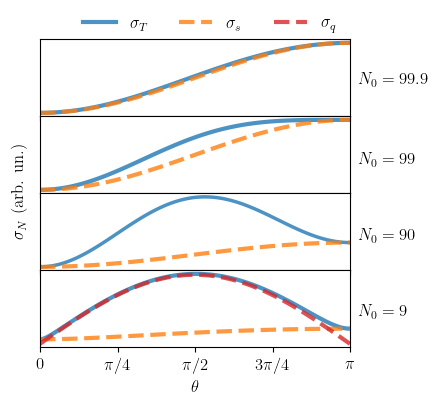

In [15]:
fig, axs = plt.subplots(4, 1, figsize=(4, 4), sharex=True)

theta = np.linspace(0, np.pi, 100)

axs[0].plot(theta, sigma_total2(theta, 99.9, 100, 0)**.5/199.9, lw=3, alpha=.8)
axs[0].plot(theta, sigma_s2(theta, 99.9, 100)**.5/199.9, linestyle='--', lw=3, alpha=.8)
axs[0].set_yticks([])

axs[1].plot(theta, sigma_total2(theta, 99, 100, 0)**.5/199, lw=3, alpha=.8)
axs[1].plot(theta, sigma_s2(theta, 99, 100)**.5/199, linestyle='--', lw=3, alpha=.8)
axs[1].set_yticks([])

axs[2].plot(theta, sigma_total2(theta, 90, 100, 0)**.5/190, lw=2.5, alpha=.8)
axs[2].plot(theta, sigma_s2(theta, 90, 100)**.5/190, linestyle='--', lw=3, alpha=.8)
axs[2].set_yticks([])

axs[3].plot(theta, sigma_total2(theta, 9, 100, 0)**.5/109, lw=3, alpha=.8, label=r'$\sigma_T$')
axs[3].plot(theta, sigma_s2(theta, 9, 100)**.5/109, linestyle='--', lw=3, alpha=.8, label=r'$\sigma_{s}$')
axs[3].plot(theta, sigma_q2(theta, 9, 100)**.5/109, linestyle='--', lw=3, alpha=.8, label=r'$\sigma_{q}$', color='C3')
axs[3].set_yticks([])
axs[3].set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

fig.text(.92, .78, r'$N_0 = 99.9$', va='center', ha='left')
fig.text(.92, .58, r'$N_0 = 99$', va='center', ha='left')
fig.text(.92, .39, r'$N_0 = 90$', va='center', ha='left')
fig.text(.92, .2, r'$N_0 = 9$', va='center', ha='left')

fig.text(0.05, .5, r'$\sigma_N$ (arb. un.)', rotation=90, va='center')

# fig.suptitle(r'Total Noise, $N_1=100$', fontsize=14)
axs[3].legend(loc='upper right', ncol=3, frameon=False, bbox_to_anchor=(1, 4.5))

axs[0].set_xlim(0, np.pi)
axs[-1].set_xlabel(r'$\theta$')
fig.subplots_adjust(hspace=0)

plt.savefig('./figures/sigma_analytical.pdf', bbox_inches='tight', dpi=300)

# 2. <a id='toc2_'></a>[Protocol Execution](#toc0_)

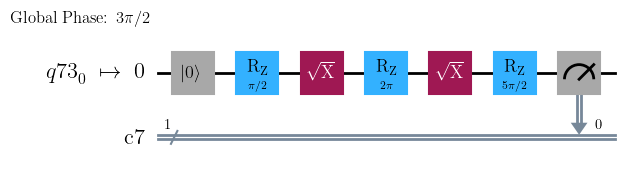

In [52]:
# Selects the backend, can either be osaka, brisbane or kyoto
backend = service.get_backend('ibm_brisbane')

# Get the time constrains of the backend for transpilation
backend_timing = backend.configuration().timing_constraints
timing_constraints = TimingConstraints(
                                        granularity=backend_timing['granularity'],
                                        min_length=backend_timing['min_length'],
                                        pulse_alignment=backend_timing['pulse_alignment'],
                                        acquire_alignment=backend_timing['acquire_alignment']
                                    )

# the index of theta needs to be adjusted every run
itr_theta = 39
transpiled_protocol = optmized_transpilation(backend, rabi_protocol(theta[itr_theta], 0), timing_constraints)
# Runs on the backend the transpiled protocol
transpiled_protocol.draw('mpl', idle_wires=False)

In [53]:
# run the transpiled protocol
backend.run(transpiled_protocol, shots=100)

<RuntimeJob('ctz0r8sfhad0008tjzvg', 'circuit-runner')>

In [5]:
# Get the jobs from the service
jobs = service.jobs(limit=40, pending=False)
# Flips the jobs to have the same order as the theta array
jobs = np.flip(jobs)

# Get the mean and standard deviation of the results
mean, std = get_mu_std(jobs)

# save the data according to the backend being used
np.savetxt('./exp_data/brisbane/std_dev.txt', np.c_[theta, mean, std])

# 3. <a id='toc3_'></a>[Results](#toc0_)

The results are loaded and fitted with the analytical formulas of $\langle\hat{N} \rangle$ and $\sigma_N$, from which the quality parameters of each token are extracted. Overall, Sherbrooke and Kyiv present the most optimal parameters.

In [2]:
# Load the data
brisbane_data = np.loadtxt('./exp_data/brisbane/std_dev.txt')
osaka_data = np.loadtxt('./exp_data/osaka/std_dev.txt')
kyoto_data = np.loadtxt('./exp_data/kyoto/std_dev.txt')
sherbrooke_data = np.loadtxt('./exp_data/sherbrooke/std_dev.txt')
kyiv_data = np.loadtxt('./exp_data/kyiv/std_dev.txt')

# Fit the data to the combined function
params_brisbane, cov_brisabane = curve_fit(combined_fit, theta, np.concatenate((brisbane_data[:,1], brisbane_data[:,2])), maxfev=10000, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
params_osaka, cov_osaka = curve_fit(combined_fit, theta_osaka, np.concatenate((osaka_data[:,1], osaka_data[:,2])), maxfev=10000, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
params_kyoto, cov_kyoto = curve_fit(combined_fit, theta, np.concatenate((kyoto_data[:,1], kyoto_data[:,2])), maxfev=10000, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
params_sherbrooke, cov_sherbrooke = curve_fit(combined_fit, theta, np.concatenate((sherbrooke_data[:,1], sherbrooke_data[:,2])), maxfev=10000, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
params_kyiv, cov_kyiv = curve_fit(combined_fit, theta, np.concatenate((kyiv_data[:,1], kyiv_data[:,2])), maxfev=10000, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

# print the results
print('Osaka')
print(f'\t N0 = {params_osaka[0]/(params_osaka[0] + params_osaka[1])}')
print(f'\t N1 = {params_osaka[1]/(params_osaka[0] + params_osaka[1])}')
print(f'\t c = {(params_osaka[1]- params_osaka[0])/(params_osaka[0] + params_osaka[1])}')
print(f'\t sigma_exp = {params_osaka[2]/(params_osaka[0] + params_osaka[1])}')

print('Brisbane')
print(f'\t N0 = {params_brisbane[0]/(params_brisbane[0] + params_brisbane[1])}')
print(f'\t N1 = {params_brisbane[1]/(params_brisbane[0] + params_brisbane[1])}')
print(f'\t c = {(params_brisbane[1]- params_brisbane[0])/(params_brisbane[0] + params_brisbane[1])}')
print(f'\t sigma_exp = {params_brisbane[2]/(params_brisbane[0] + params_brisbane[1])}')

print('Kyoto')
print(f'\t N0 = {params_kyoto[0]/(params_kyoto[0] + params_kyoto[1])}')
print(f'\t N1 = {params_kyoto[1]/(params_kyoto[0] + params_kyoto[1])}')
print(f'\t c = {(params_kyoto[1]- params_kyoto[0])/(params_kyoto[0] + params_kyoto[1])}')
print(f'\t sigma_exp = {params_kyoto[2]/(params_kyoto[0] + params_kyoto[1])}')

print('Sherbrooke')
print(f'\t N0 = {params_sherbrooke[0]/(params_sherbrooke[0] + params_sherbrooke[1])}')
print(f'\t N1 = {params_sherbrooke[1]/(params_sherbrooke[0] + params_sherbrooke[1])}')
print(f'\t c = {(params_sherbrooke[1]- params_sherbrooke[0])/(params_sherbrooke[0] + params_sherbrooke[1])}')
print(f'\t sigma_exp = {params_sherbrooke[2]/(params_sherbrooke[0] + params_sherbrooke[1])}')

print('Kyiv')
print(f'\t N0 = {params_kyiv[0]/(params_kyiv[0] + params_kyiv[1])}')
print(f'\t N1 = {params_kyiv[1]/(params_kyiv[0] + params_kyiv[1])}')
print(f'\t c = {(params_kyiv[1]- params_kyiv[0])/(params_kyiv[0] + params_kyiv[1])}')
print(f'\t sigma_exp = {params_kyiv[2]/(params_kyiv[0] + params_kyiv[1])}')

Osaka
	 N0 = 0.05200282069784943
	 N1 = 0.9479971793021507
	 c = 0.8959943586043012
	 sigma_exp = 0.15845001039120335
Brisbane
	 N0 = 0.07838269233721101
	 N1 = 0.9216173076627889
	 c = 0.843234615325578
	 sigma_exp = 0.2698542694169995
Kyoto
	 N0 = 0.2184532817491268
	 N1 = 0.7815467182508733
	 c = 0.5630934365017465
	 sigma_exp = 0.3768218882770441
Sherbrooke
	 N0 = 0.0070012142526520655
	 N1 = 0.9929987857473479
	 c = 0.9859975714946958
	 sigma_exp = 1.7175122918426523e-05
Kyiv
	 N0 = 0.024802893315384274
	 N1 = 0.9751971066846157
	 c = 0.9503942133692314
	 sigma_exp = 0.02641329313849933


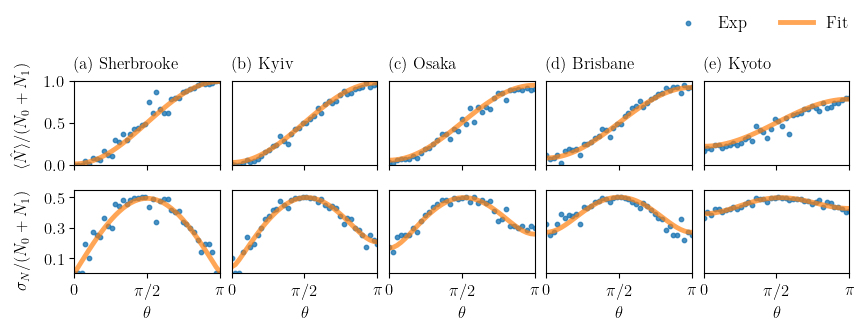

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(10, 2.5), sharex=True)

axs[0][0].set_ylabel(r'$\langle \hat{N} \rangle /{(N_0+N_1)}$', labelpad=10, y=.6)
axs[1][0].set_ylabel(r'$\sigma_{N}/{(N_0+N_1)}$', labelpad=10, y=0.4)
axs[1][0].set_xlim(0, np.pi)
axs[1][0].set_xticks([0, np.pi/2, np.pi], [r'0', r'$\pi/2$', r'$\pi$'])

axs[0][0].scatter(theta, sherbrooke_data[:,1], alpha=.8, s=10)
axs[0][0].plot(theta, combined_fit(theta, *params_sherbrooke)[:40], lw=3.5, color='C1', alpha=.7)
axs[0][0].set_title('(a) Sherbrooke', fontsize=12, x=0, y=1.15, transform=axs[0][0].transAxes, ha='left')

axs[1][0].scatter(theta, sherbrooke_data[:,2], alpha=.8, s=10)
axs[1][0].plot(theta, combined_fit(theta, *params_sherbrooke)[40:], lw=3.5, color='C1', alpha=.7)
axs[1][0].set_xlabel(r'$\theta$')

axs[0][1].scatter(theta, kyiv_data[:,1], alpha=.8, s=10)
axs[0][1].plot(theta, combined_fit(theta, *params_kyiv)[:40], lw=3.5, color='C1', alpha=.7)
axs[0][1].set_title('(b) Kyiv', fontsize=12, x=0, y=1.15, transform=axs[0][1].transAxes, ha='left')

axs[1][1].scatter(theta, kyiv_data[:,2], alpha=.8, s=10)
axs[1][1].plot(theta, combined_fit(theta, *params_kyiv)[40:], lw=3.5, color='C1', alpha=.7)
axs[1][1].set_xlabel(r'$\theta$')

axs[0][2].scatter(theta_osaka, osaka_data[:,1], alpha=.8, s=10)
axs[0][2].plot(theta_osaka, combined_fit(theta_osaka, *params_osaka)[:73], lw=3.5, color='C1', alpha=.7)
axs[0][2].set_title('(c) Osaka', fontsize=12, x=0, y=1.15, transform=axs[0][2].transAxes, ha='left')

axs[1][2].scatter(theta_osaka, osaka_data[:,2], alpha=.8, s=10)
axs[1][2].plot(theta_osaka, combined_fit(theta_osaka, *params_osaka)[73:], lw=3.5, color='C1', alpha=.7)
axs[1][2].set_xlabel(r'$\theta$')

axs[0][3].scatter(theta, brisbane_data[:,1], alpha=.8, label='Exp', s=10)
axs[0][3].plot(theta, combined_fit(theta, *params_brisbane)[:40], lw=3.5, color='C1', alpha=.7, label='Fit')
axs[0][3].set_title('(d) Brisbane', fontsize=12, x=0, y=1.15, transform=axs[0][3].transAxes, ha='left')

axs[1][3].scatter(theta,  brisbane_data[:,2], alpha=.8, s=10)
axs[1][3].plot(theta, combined_fit(theta, *params_brisbane)[40:], lw=3.5, color='C1', alpha=.7)
axs[1][3].set_xlabel(r'$\theta$')

axs[0][4].scatter(theta, kyoto_data[:,1], alpha=.8, s=10)
axs[0][4].plot(theta, combined_fit(theta, *params_kyoto)[:40], lw=3.5, color='C1', alpha=.7)
axs[0][4].set_title('(e) Kyoto', fontsize=12, x=0, y=1.15, transform=axs[0][4].transAxes, ha='left')

axs[1][4].scatter(theta, kyoto_data[:,2], alpha=.8, s=10)
axs[1][4].plot(theta, combined_fit(theta, *params_kyoto)[40:], lw=3.5, color='C1', alpha=.7)
axs[1][4].set_xlabel(r'$\theta$')

for itr in range(5):
    axs[0][itr].set_ylim(0, 1)
    axs[1][itr].set_ylim(0, .55)
    axs[0][itr].set_yticks([])
    axs[1][itr].set_yticks([])

axs[0][0].set_yticks([0, .5, 1])
axs[1][0].set_yticks([0.1, .3, .5])

fig.legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(.81, 1.2))

fig.subplots_adjust(hspace=0.3, wspace=0.08)

plt.savefig('./figures/IBMQ_rabi.pdf', bbox_inches='tight', dpi=300, transparent=True)